In [495]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats.distributions import chi2
import scipy
from sklearn.metrics import confusion_matrix

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn 

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [ ]:
# df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")
df1 = pd.read_csv("~/selCoefEst/traindata/trip-2021-10-20.csv")

In [ ]:
# dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
# idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [ ]:
## read-in saved model (no retraining required)
prob_model = tf.keras.models.load_model('saved_model/lognorm_model', compile=False)
negloglik = lambda y, p_y: -tf.reduce_sum(p_y.log_prob(y))
# compile the loaded model with the custome objects
prob_model.compile(optimizer='adam', loss=negloglik)

In [556]:
gamma

array([-1.000000e+02, -6.812921e+01, -4.641589e+01, -3.162278e+01,
       -2.154435e+01, -1.467799e+01, -1.000000e+01, -6.812921e+00,
       -4.641589e+00, -3.162278e+00, -2.154435e+00, -1.467799e+00,
       -1.000000e+00, -6.812921e-01, -4.641589e-01, -3.162278e-01,
       -2.154435e-01, -1.467799e-01, -1.000000e-01, -6.812921e-02,
       -4.641589e-02, -3.162278e-02, -2.154435e-02, -1.467799e-02,
       -1.000000e-02])

In [618]:
## picking a choice of g1 and g2 & creating a new data frame
trueg1 = -1.
trueg2 = -100.
# 2000 x 3 (first 1000 is g1, second 1000 is g2)
newdf1 = df1.iloc[np.ravel(np.where(dat[:,1]==trueg1)),0:3].append(df1.iloc[np.ravel(np.where(dat[:,1]==trueg2)),0:3])
newdat = newdf1.to_numpy()

In [ ]:
# log P(Xl | gamma)
def get_lp_xl(g, Xlred, N=2500):
    """function to compute L(gamma|Xl), where gamma is a range of values and Xl is a given set of freqs"""
    res = np.empty(len(Xlred))
    ub = np.exp(2.*g)*scipy.special.expi(-2.*g*0.25/N) - scipy.special.expi(2.*g*(1-0.25/N)) - np.exp(2.*g)*(np.log(0.25/N) - np.log(1-0.25/N))
    #scipy.special.expi(-g*0.25/N) - np.exp(-g)*scipy.special.expi(g*(1-0.25/N)) - np.log(0.25/N) + np.log(1-0.25/N)
    lb = np.exp(2.*g)*scipy.special.expi(2.*g*(0.25/N-1)) - scipy.special.expi(2.*g*0.25/N) - np.exp(2.*g)*(np.log(1-0.25/N) - np.log(0.25/N))
    #scipy.special.expi(g*(0.25/N-1)) - np.exp(-g)*scipy.special.expi(g*0.25/N) - np.log(1-0.25/N) + np.log(0.25/N)
    scalfact = (ub - lb)/np.expm1(2.*g)
    # return a vector...
    for ix, x in enumerate(Xlred):
        res[ix] = np.exp(2.*g)*scipy.special.expi(2.*g*(x-1)) - scipy.special.expi(2.*g*x) - np.exp(2.*g)*(np.log(1-x) - np.log(x))
        #-np.log(x) - np.log(1.-x) + np.log((1.-np.exp(-2.*g*(1.-x)))/(1.-np.exp(-2.*g))) / scalfact
    #res = np.sum(-np.log(xl) - np.log(1.-xl) + np.log((1.-np.exp(-2.*g*(1.-xl)))/(1.-np.exp(-2.*g)))) / scalfact
    return np.log(res/scalfact)

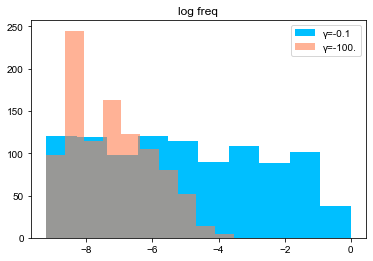

In [623]:
# plt.hist(np.log(newdat[0:1000,2]),color='deepskyblue',label='γ=-0.1')
# plt.title('log allele age')
# plt.hist(np.log(newdat[1000:2000,2]),alpha=0.6,color='coral',label='γ=-100.')
# plt.legend()
plt.hist(np.log(newdat[0:1000,0]),color='deepskyblue',label='γ=-0.1')
plt.title('log freq')
plt.hist(np.log(newdat[1000:2000,0]),alpha=0.6,color='coral',label='γ=-100.')
plt.legend()

In [ ]:
# log P(Xl, al | gamma)
def get_lp_alxl(g, Xlred, logalred, prob_model=prob_model):
    """function to compute L(gamma|Xl,al), where gamma is a range of values and Xl & al are given sets of freqs and ages"""

    res = np.empty(len(logalred))

    ahat = prob_model(np.vstack((np.log(Xlred),np.repeat(g,len(Xlred)))).T)
    preds = ahat.mean().numpy()
    preds_sd = ahat.stddev().numpy()

    for ia, a in enumerate(logalred):
        res[ia] = scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia]) 
    return res

### Goal: investigate working of `get_lp_alxl` function
Below, I will use these disparate data (coming from two vastily different gammas, see hist above) and see whether there is a higher likelihood for $\gamma=-0.1$ (as compared to $\gamma=-100.0$) when I use ages above $e^6$, because alleles strongly selected against should not go live for very long. 

In [559]:
res = np.empty(len(newdat[np.where(np.log(newdat[:,2])>6)[0],0]))
ahat = prob_model(np.vstack((np.log(newdat[np.where(np.log(newdat[:,2])>6)[0],0]),np.repeat(trueg1,len(res)))).T)
preds = ahat.mean().numpy()
preds_sd = ahat.stddev().numpy()
for ia, a in enumerate(np.log(newdat[np.where(np.log(newdat[:,2])>6)[0],2])):
    res[ia] = scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia])

In [560]:
res2 = np.empty(len(res))
ahat2 = prob_model(np.vstack((np.log(newdat[np.where(np.log(newdat[:,2])>6)[0],0]),np.repeat(trueg2,len(res2)))).T)
preds2 = ahat2.mean().numpy()
preds_sd2 = ahat2.stddev().numpy()
for ia, a in enumerate(np.log(newdat[np.where(np.log(newdat[:,2])>6)[0],2])):
    res2[ia] = scipy.stats.norm.logpdf(a, loc=preds2[ia], scale=preds_sd2[ia])

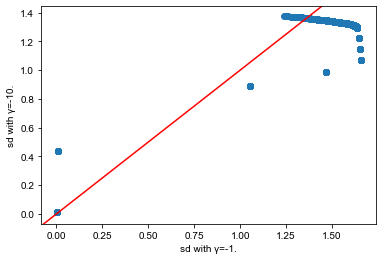

In [577]:
plt.plot(preds_sd,preds_sd2,'o',)
plt.xlabel('sd with γ=-1.')
plt.ylabel('sd with γ=-10.')
plt.axline((0,0),(1,1),color='red')

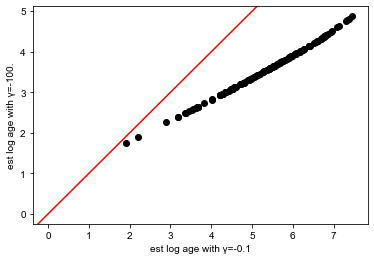

In [562]:
# clear downward bias with gamma=-0.1 (which is what we want - gamma=-100 should not predict high allele ages)
plt.plot(preds,preds2,'o',color='k')
plt.xlabel('est log age with γ=-0.1')
plt.ylabel('est log age with γ=-100.')
plt.axline((0,0),(1,1),color='red')

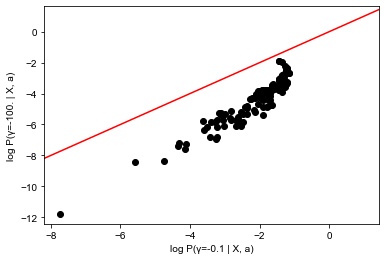

In [563]:
# this trend is good too, since we see that most points are below the 1:1 line indicating that most obs have a higher log prob of being gamma=-0.1
plt.plot(res,res2,'o',color='k')
plt.xlabel('log P(γ=-0.1 | X, a)')
plt.ylabel('log P(γ=-100. | X, a)')
plt.axline((0,0),(1,1),color='red')

In [564]:
# over 97% of observations fall into the gamma=-0.1 vs gamma=-100. category - which is correct
# ~91% of observations fall into the gamma=-1. vs gamma=-10. category - which is still good
np.sum(res>res2)/len(res)

1.0

In [565]:
## check performance of get_lp_alxl as a classifier (create confusion matrix)
totalres = np.empty(len(newdat))
ahat = prob_model(np.vstack((np.log(newdat[:,0]),np.repeat(trueg1,len(newdat[:,0])))).T)
preds = ahat.mean().numpy()
preds_sd = ahat.stddev().numpy()
for ia, a in enumerate(np.log(newdat[:,2])):
    totalres[ia] = scipy.stats.norm.logpdf(a, loc=preds[ia], scale=preds_sd[ia])

In [566]:
totalres2 = np.empty(len(newdat))
ahat2 = prob_model(np.vstack((np.log(newdat[:,0]),np.repeat(trueg2,len(newdat[:,0])))).T)
preds2 = ahat2.mean().numpy()
preds_sd2= ahat2.stddev().numpy()
for ia, a in enumerate(np.log(newdat[:,2])):
    totalres2[ia] = scipy.stats.norm.logpdf(a, loc=preds2[ia], scale=preds_sd2[ia])

In [567]:
# 58.6% accuracy rate (diags), lot more -100. predicted as -0.1, fewer the other way around
# 55.5% accuracy rate (diags), lot more (<2x) -100. predicted as -10., fewer the other way around
# 50.3% accuracy rate (daigs), lot more (>3x) -10. predicted as -1., fewwer the other way around
confusion_matrix(np.array(['A']*1000 + ['B']*1000),np.array(['A' if x==True else 'B' for x in totalres>totalres2]),labels=['A','B'])/2000

array([[0.3435, 0.1565],
       [0.2885, 0.2115]])

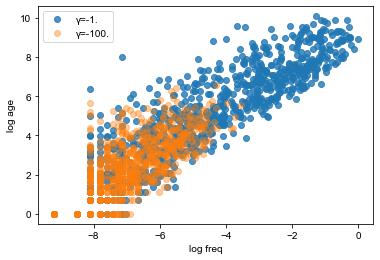

In [619]:
# plotting the ages vs freqs for each selection coefficient
plt.plot(np.log(newdat[0:1000,0]),np.log(newdat[0:1000,2]),'o',label='γ=-1.',alpha=0.8)
plt.plot(np.log(newdat[1000:2000,0]),np.log(newdat[1000:2000,2]),'o',label='γ=-100.',alpha=0.4)
plt.xlabel('log freq')
plt.ylabel('log age')
plt.legend() 

In [591]:
scipy.stats.norm.logpdf(np.log(11),preds2[11],preds_sd2[11])

array([-1.22498702])

CPU times: user 20.8 ms, sys: 5.99 ms, total: 26.7 ms
Wall time: 32.2 ms


Text(0, 0.5, 'log-lik units')

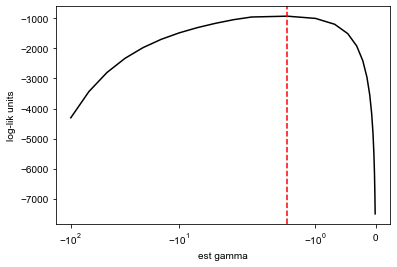

In [621]:
%%time
## assuming only one selection coefficient and only freq info
# sin_onlyfreq = np.empty(len(gamma))
# for ig, g in enumerate(gamma):
#     # sum log prob for each locus
#     sin_onlyfreq[ig] = np.sum(get_lp_xl(g, newdat[:,0]))
plt.plot(gamma,sin_onlyfreq,'k')
plt.xlabel('est gamma')
plt.xscale('symlog')
plt.axvline(gamma[np.argmax(sin_onlyfreq)], color='red', linestyle='--')
plt.ylabel('log-lik units')

In [569]:
%%time
## assuming two selection coefficients and only freq info (split 50/50)
dub_onlyfreq = np.empty((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma):
        dub_onlyfreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_xl(g1, newdat[:,0])) + 0.5*np.exp(get_lp_xl(g2, newdat[:,0]))))

CPU times: user 23.4 s, sys: 136 ms, total: 23.5 s
Wall time: 28.3 s


([<matplotlib.axis.YTick at 0x7fc03bd3a6a0>,
 [Text(0, 0, '-100.0'),
  Text(0, 4, '-21.54'),
  Text(0, 9, '-3.16'),
  Text(0, 14, '-0.46'),
  Text(0, 19, '-0.07'),
  Text(0, 24, '-0.01')])

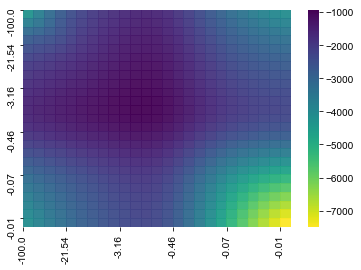

In [570]:
seaborn.heatmap(dub_onlyfreq,alpha=0.95,cmap='viridis_r',)
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))

In [622]:
?seaborn.heatmap

Signature:
seaborn.heatmap(
    data,
    *,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, other

In [ ]:
gamma[np.linspace(0,24,6,dtype='int')]

In [ ]:
get_lp_alxl(-10., dat[:,0], np.log(dat[:,2]))

CPU times: user 16.5 ms, sys: 971 µs, total: 17.5 ms
Wall time: 20.5 ms


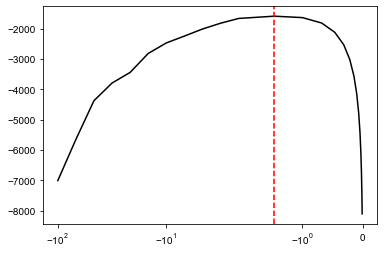

In [608]:
%%time
## assuming only one selection coefficient and both age & freq info
# sin_agefreq = np.empty(len(gamma))
# for ig, g in enumerate(gamma):
#     sin_agefreq[ig] = np.sum(get_lp_alxl(g, newdat[:,0], np.log(newdat[:,2])) + get_lp_xl(g, newdat[:,0]))

plt.plot(gamma,sin_agefreq,'k')
plt.xscale('symlog')
plt.axvline(gamma[np.argmax(sin_agefreq)], color='red', linestyle='--')

In [607]:
sin_agefreq

array([-7011.45258105, -5655.26643593, -4377.15627758, -3796.32496427,
       -3446.07767038, -2821.03373888, -2474.54356242, -2249.35529435,
       -2016.19156253, -1825.03537111, -1667.87655793, -1593.27759057,
       -1640.63220896, -1818.8732341 , -2124.78932402, -2532.54636191,
       -3019.56564088, -3564.55100553, -4152.26530207, -4771.13776929,
       -5412.6517226 , -6070.68274948, -6740.88032462, -7420.18486945,
       -8106.42960042])

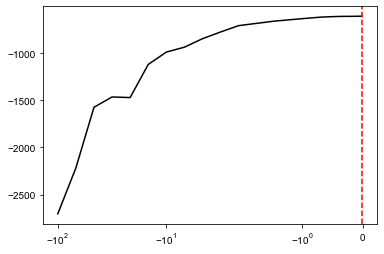

In [611]:
## assuming only one selection coefficient and only age info
# sin_onlyage = np.empty(len(gamma))
# for ig, g in enumerate(gamma):
#     sin_onlyage[ig] = np.sum(get_lp_alxl(g, newdat[:,0], np.log(newdat[:,2])))

plt.plot(gamma,sin_onlyage,'k')
plt.xscale('symlog')
plt.axvline(gamma[np.argmax(sin_onlyage)], color='red', linestyle='--')

In [610]:
sin_onlyage

array([-2703.83452552, -2216.85383131, -1573.97879217, -1464.73098629,
       -1470.70363078, -1119.86805864,  -988.82653801,  -936.8260279 ,
        -846.67480332,  -775.5988186 ,  -708.05620585,  -660.68659416,
        -634.00438303,  -617.40223807,  -612.03522642,  -609.92695568,
        -609.70029715,  -609.26389815,  -608.82762248,  -608.49389925,
        -608.26808088,  -608.12512078,  -608.03311327,  -607.97593323,
        -607.93343753])

In [440]:
%%time
## assuming two selection coefficients and only freq info (split 50/50)
dub_agefreq = np.empty((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma):
        dub_agefreq[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,0], np.log(newdat[:,2])) + get_lp_xl(g1, newdat[:,0])) + 
        0.5*np.exp(get_lp_alxl(g2, newdat[:,0], np.log(newdat[:,2])) + get_lp_xl(g2, newdat[:,0]))))

CPU times: user 4min 15s, sys: 1.5 s, total: 4min 16s
Wall time: 4min 28s


In [441]:
%%time
## assuming two selection coefficients and only age info (split 50/50)
dub_onlyage = np.empty((len(gamma),len(gamma))) # need a 2d search
for ig1, g1 in enumerate(gamma):
    for ig2, g2 in enumerate(gamma):
        dub_onlyage[ig1, ig2] = np.sum(np.log(0.5*np.exp(get_lp_alxl(g1, newdat[:,0], np.log(newdat[:,2]))) + 
        0.5*np.exp(get_lp_alxl(g2, newdat[:,0], np.log(newdat[:,2])))))

CPU times: user 3min 50s, sys: 1.33 s, total: 3min 51s
Wall time: 3min 59s


([<matplotlib.axis.YTick at 0x7fc05d11b640>,
 [Text(0, 0, '-100.0'),
  Text(0, 4, '-21.54'),
  Text(0, 9, '-3.16'),
  Text(0, 14, '-0.46'),
  Text(0, 19, '-0.07'),
  Text(0, 24, '-0.01')])

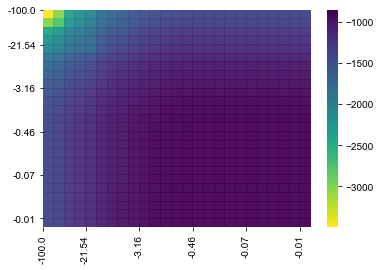

In [600]:
seaborn.heatmap(dub_onlyage,alpha=0.95,xticklabels=gamma,yticklabels=gamma,cmap='viridis_r')
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))

([<matplotlib.axis.YTick at 0x7fc05c208f40>,
 [Text(0, 0, '-100.0'),
  Text(0, 4, '-21.54'),
  Text(0, 9, '-3.16'),
  Text(0, 14, '-0.46'),
  Text(0, 19, '-0.07'),
  Text(0, 24, '-0.01')])

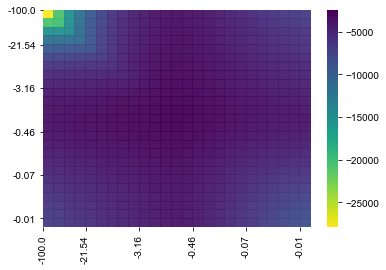

In [601]:
# plt.imshow(dub_agefreq,alpha=0.9,interpolation='none')
# plt.colorbar()
seaborn.heatmap(dub_agefreq,alpha=0.95,xticklabels=gamma,yticklabels=gamma,cmap='viridis_r')
plt.xticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))
plt.yticks(np.linspace(0,24,6,dtype='int'),gamma[np.linspace(0,24,6,dtype='int')].round(2))

In [602]:
## get MLE from calculated matrices/vectors
estgonlyfreq = gamma[np.argmax(sin_onlyfreq)]

estgagefreq = gamma[np.argmax(sin_agefreq)]

estg1onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[0]]
estg2onlyfreq = gamma[np.unravel_index(dub_onlyfreq.argmax(), dub_onlyfreq.shape)[1]]

estg1agefreq = gamma[np.unravel_index(dub_agefreq.argmax(), dub_agefreq.shape)[0]]
estg2agefreq = gamma[np.unravel_index(dub_agefreq.argmax(), dub_agefreq.shape)[1]]

In [603]:
## get likelihood ratio value
lambfreq = -2.*(dub_onlyfreq[gamma==estg1onlyfreq,gamma==estg2onlyfreq] - sin_onlyfreq[gamma==estgonlyfreq])
print(chi2.sf(lambfreq, 1))

lambagefreq = -2.*(dub_agefreq[gamma==estg1agefreq,gamma==estg2agefreq] - sin_agefreq[gamma==estgagefreq])
print(chi2.sf(lambagefreq, 1))

[1.]
[0.]


In [606]:
lambfreq

array([-0.])

In [604]:
print(estgonlyfreq, estgagefreq)
print(estg1onlyfreq, estg2onlyfreq)
print(estg1agefreq, estg2agefreq)

-1.467799 -1.467799
-1.467799 -1.467799
-1.0 -1.0
